I want to explain the procedure of developing the code for the paper [Statistical characterization of noise for spatial standardization of CT scans: Enabling comparison with multiple kernels and doses](../resources/paper.pdf).
The Algorithm1 of paper and Algorithm2 are pretty the same. I am going to go straight through the Algorithm2.
Here is the pseudo-code of the algorithm.

![Algorithm2](../resources/figs/algorithm2.png)

P.S: I have corrected a small part of the algorithm based on the formula written before (and I think its kinda obvious because the sigma is on the variable "s").
First, Let's add this jupyther notebook to the project so that we can import some useful functions.

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

Now let's try if it works.

In [2]:
from utility.utils import central_gamma_pdf
print(central_gamma_pdf(100, 10,10))

0.01251100357211333


Good! So let's start implementing the algorithm. We should find a chest ct scan. Recently I've been working on the LUNA16 dataset, so I can use one little slice of that dataset because I have it on my local storage!

(It would be difficult to upload a big 3d-image to Github, So I sliced it and uploaded a 2d-image array in .npy format)

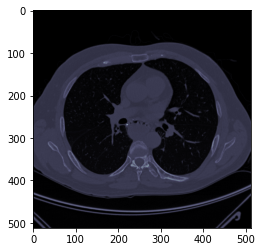

In [3]:
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
img = np.load('../resources/2d_img.npy')
plt.imshow(img, cmap=plt.cm.bone)
plt.show()

Now let's see what is the distribution of the values for HUs.

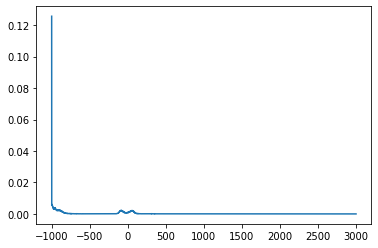

In [4]:
flat = img.flatten()
(unique, counts) = np.unique(flat, return_counts=True)
pdf = counts/len(flat)
plt.plot(unique, pdf)
plt.show()

Hmmm...
So, 

# Algorithm2:

Centering the HU values:

In [5]:
# centering the data
delta = -1030
y = img - delta

According to Fig. 1 of the paper, we can have 9 components which their HU values are: [340, 240, 100, 0, -160, -370, -540, -810, -987]

In [6]:
# mu, E[.] or expected value for nine components written in Fig. 1 of the paper 
MU = np.array([340, 240, 100, 0, -160, -370, -540, -810, -987]) - delta
# number of components
J = len(MU)

We should make theta. Theta consists of phi, alpha, and beta.

According to the paper, sum of phis must be 1. 

And alpha[j] = mu[j] / beta[j].

So:


In [7]:
# initial guess of parameters
# we assume that theta[0] = phi, theta[1] = alpha, theta[2] = beta
not_normalized_phi = np.random.random(J)
sum_of_phis = sum(not_normalized_phi)
shape_of_theta = (3, J)
theta = np.zeros(shape=shape_of_theta)
random_alphas = list(range(10, J + 10))
theta[:, :] = np.array([[i / sum_of_phis for i in not_normalized_phi], random_alphas,
                        [MU[j] / random_alphas[j] for j in range(J)]])

Now we should make first gamma. I guess we can form it by random values, but lets follow the instructions of the paper:

In [8]:
from utility.utils import central_gamma_pdf

# Eq. 18
shape_of_gamma = tuple(list(y.shape) + [J])
gamma = np.zeros(shape=shape_of_gamma)
for i, a in enumerate(y):
    for j, b in enumerate(a):
        sum_of_j_elements = 0
        for k in range(J):
            val = theta[0, k] * central_gamma_pdf(y[i, j], alpha=theta[1, k], beta=theta[2, k])
            gamma[i, j, k] = val
            sum_of_j_elements += val
        gamma[i, j] = gamma[i, j] / sum_of_j_elements

And finally, lets set sum constants:

In [9]:
max_iter = 10
tol = 0.1
err = np.Infinity
n = 0

Let's define the main loop. It's pretty straight forward. We assume the whole 2d-image as a single neighborhood. Eq. 18 was used before, so the only new thing is computing theta.

The difficult part is to compute alpha. Looking at this, may ease everything for you:

![algorithm3 computing alpha](../resources/figs/algorithm3_summation.png)

In [10]:
while err > tol and n < max_iter:
    n += 1
    first_form_summation = np.sum(gamma * (np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    second_form_summation = np.sum(gamma * np.log(np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    denominator_summation = np.sum(gamma, axis=(0, 1)).reshape(J)
    new_alpha = (first_form_summation - second_form_summation) / denominator_summation - 1
    new_beta = np.array(MU) / new_alpha
    new_phi = denominator_summation / y.size
    new_theta = np.array([new_phi, new_alpha, new_beta])
    # Eq. 18
    shape_of_gamma = gamma.shape
    new_gamma = np.zeros(shape=shape_of_gamma)
    for i, a in enumerate(y):
        for j, b in enumerate(a):
            sum_of_j_elements = 0
            for k in range(J):
                val = theta[0, k] * central_gamma_pdf(y[i, j], alpha=theta[1, k], beta=theta[2, k])
                new_gamma[i, j, k] = val
                sum_of_j_elements += val
            new_gamma[i, j] = new_gamma[i, j] / sum_of_j_elements
    err = np.linalg.norm(new_theta - theta) / np.linalg.norm(theta)
    theta = new_theta
    gamma = new_gamma
    print(n)

1
2


# Algorithm3
Now we've done the Algorithm2, we are going to implement algorithm3. The pseudo-code of the algorithm:

![Algorithm3](../resources/figs/algorithm3.png)

Where the Eq. 42 is:

![Eq. 42](../resources/figs/eq.42.png)

But, I think there is a mistake of authors again. Because of the output of the right side of the Eq. 42 has 2 variables: r and j (in our version image is 2d, so we have 3 variables: instead of r, (x,y) represents location and j for each component)

But in the last assignment of the Algorithm3, there is a bug.

![bug](../resources/figs/algorithm3_bug.png)

As you can see, one of the matrices has one ax and the other one has got two axis. This way, if we broadcast the matrix which has one ax, the resulting y_stab will not be a 2d image, it will have an axis regarding components (j).

I assumed that this means we should compute E[.] of the matrix containing two axis using phi.

Let's set the constant value of C:

In [11]:
C = 10

I will define a simple function named "broadcast_3d_tile". Its functionality is very simple, expands the input matrix to any integer size we want.
Take a look at this example:

![broadcast_tile](../resources/figs/broadcast_tile.png)

In [12]:
def broadcast_3d_tile(matrix, h, w, d):
    m, n, o = matrix.shape[0] * h, matrix.shape[1] * w, matrix.shape[2] * d
    return np.broadcast_to(matrix.reshape(matrix.shape[0], 1, matrix.shape[1], 1, matrix.shape[2], 1),
                           (matrix.shape[0], h, matrix.shape[1], w, matrix.shape[2], d)).reshape(m, n, o)

Then we try to get stable_y as the result of algorithm.

Take a look at the annotations on the algorithm:

![Algorithm3_with_annotations](../resources/figs/algorithm3_with_annotations.png)


In [13]:
form_of_first_mini_sclm = np.sum(np.sqrt(np.sqrt(np.expand_dims(y, axis=-1)) * gamma) * gamma, axis=(0, 1)).reshape(
    (1, 1, J))
form_of_second_mini_sclm = np.sum(np.sqrt(np.expand_dims(y, axis=-1) * gamma) * gamma, axis=(0, 1)).reshape((1, 1, J))
denominator_summation = np.sum(gamma, axis=(0, 1)).reshape((1, 1, J))
first_mini_sclm = form_of_first_mini_sclm / denominator_summation
second_mini_sclm = form_of_second_mini_sclm / denominator_summation
first_sclm = np.sum(broadcast_3d_tile(first_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
second_sclm = np.sum(broadcast_3d_tile(second_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
var_of_radical_y = second_sclm - np.power(first_sclm, 2)
stable_y = C * (np.sqrt(y) - first_sclm) / np.sqrt(var_of_radical_y) + second_sclm

And the result is:

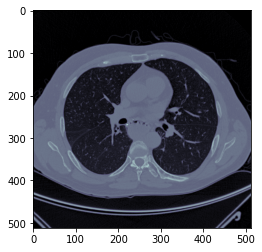

In [14]:
plt.imshow(stable_y, cmap=plt.cm.bone)
plt.show()

Let's check the distributions:

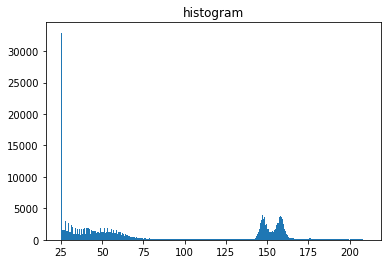

In [20]:
flat = stable_y.flatten()
plt.hist(flat, bins=list(np.arange(25, 210, 0.5)))
plt.title("histogram")
plt.show()

What if we cut out the big bin?

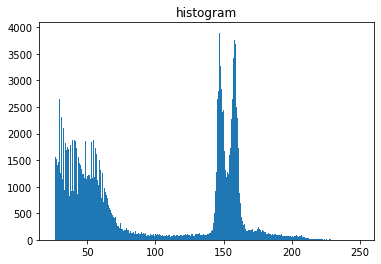

In [21]:
plt.hist(flat, bins=list(np.arange(26, 250, 0.5)))
plt.title("histogram")
plt.show()

Now, probably you can see the gamma distributions!

# My own chest ct scan :D
But, I didn't satisfy with this sample of the LUNA16 dataset. I went to a doctor and wanted him to give me my chest ct scan :D. (They gave me a CD of dicom files)
I used a slice of it (the ct scan of my own chest) to run the whole procedure, to check if it works well enough.


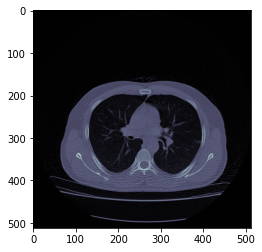

In [22]:
img = np.load('../resources/my_lungs.npy')
plt.imshow(img, cmap=plt.cm.bone)
plt.show()

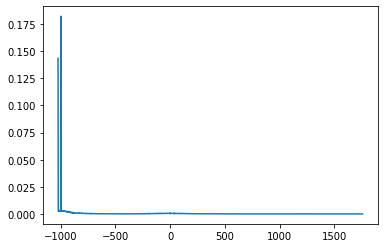

In [23]:
flat = img.flatten()
(unique, counts) = np.unique(flat, return_counts=True)
pdf = counts/len(flat)
plt.plot(unique, pdf)
plt.show()

In [24]:
from utility.utils import central_gamma_pdf


# centering the data
delta = -1030
y = img - delta

# initial guess of parameters
# we assume that theta[0] = phi, theta[1] = alpha, theta[2] = beta
not_normalized_phi = np.random.random(J)
sum_of_phis = sum(not_normalized_phi)
shape_of_theta = (3, J)
theta = np.zeros(shape=shape_of_theta)
random_alphas = list(range(10, J + 10))
theta[:, :] = np.array([[i / sum_of_phis for i in not_normalized_phi], random_alphas,
                        [MU[j] / random_alphas[j] for j in range(J)]])

# Eq. 18
shape_of_gamma = tuple(list(y.shape) + [J])
gamma = np.zeros(shape=shape_of_gamma)
for i, a in enumerate(y):
    for j, b in enumerate(a):
        sum_of_j_elements = 0
        for k in range(J):
            val = theta[0, k] * central_gamma_pdf(y[i, j], alpha=theta[1, k], beta=theta[2, k])
            gamma[i, j, k] = val
            sum_of_j_elements += val
        gamma[i, j] = gamma[i, j] / sum_of_j_elements

In [25]:
max_iter = 10
tol = 0.1
err = np.Infinity
n = 0
while err > tol and n < max_iter:
    n += 1
    first_form_summation = np.sum(gamma * (np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    second_form_summation = np.sum(gamma * np.log(np.expand_dims(y, axis=-1) / MU), axis=(0, 1)).reshape(J)
    denominator_summation = np.sum(gamma, axis=(0, 1)).reshape(J)
    new_alpha = (first_form_summation - second_form_summation) / denominator_summation - 1
    new_beta = np.array(MU) / new_alpha
    new_phi = denominator_summation / y.size
    new_theta = np.array([new_phi, new_alpha, new_beta])
    # Eq. 18
    shape_of_gamma = gamma.shape
    new_gamma = np.zeros(shape=shape_of_gamma)
    for i, a in enumerate(y):
        for j, b in enumerate(a):
            sum_of_j_elements = 0
            for k in range(J):
                val = theta[0, k] * central_gamma_pdf(y[i, j], alpha=theta[1, k], beta=theta[2, k])
                new_gamma[i, j, k] = val
                sum_of_j_elements += val
            new_gamma[i, j] = new_gamma[i, j] / sum_of_j_elements
    err = np.linalg.norm(new_theta - theta) / np.linalg.norm(theta)
    theta = new_theta
    gamma = new_gamma
    print(n)

1
2


In [26]:
form_of_first_mini_sclm = np.sum(np.sqrt(np.sqrt(np.expand_dims(y, axis=-1)) * gamma) * gamma, axis=(0, 1)).reshape(
    (1, 1, J))
form_of_second_mini_sclm = np.sum(np.sqrt(np.expand_dims(y, axis=-1) * gamma) * gamma, axis=(0, 1)).reshape((1, 1, J))
denominator_summation = np.sum(gamma, axis=(0, 1)).reshape((1, 1, J))
first_mini_sclm = form_of_first_mini_sclm / denominator_summation
second_mini_sclm = form_of_second_mini_sclm / denominator_summation
first_sclm = np.sum(broadcast_3d_tile(first_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
second_sclm = np.sum(broadcast_3d_tile(second_mini_sclm, y.shape[0], y.shape[1], 1) * theta[0, :], axis=2)
var_of_radical_y = second_sclm - np.power(first_sclm, 2)
stable_y = C * (np.sqrt(y) - first_sclm) / np.sqrt(var_of_radical_y) + second_sclm

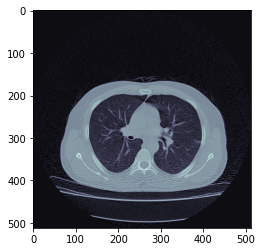

In [27]:
plt.imshow(stable_y, cmap=plt.cm.bone)
plt.show()

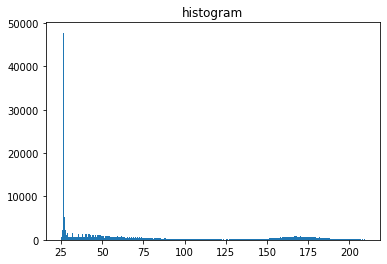

In [28]:
flat = stable_y.flatten()
plt.hist(flat, bins=list(np.arange(25, 210, 0.5)))
plt.title("histogram")
plt.show()

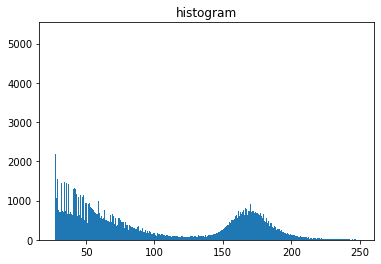

In [29]:
plt.hist(flat, bins=list(np.arange(27, 250, 0.5)))
plt.title("histogram")
plt.show()